## Import neccessary packages

In [15]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [17]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 4
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'data/'
width=256
height=256
depth=3

Function to convert images to array

In [18]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [19]:
image_list, label_list = [], []
# try:
print("[INFO] Loading images ...")
root_dir = listdir(directory_root)
for directory in root_dir :
    # remove .DS_Store from list
    if directory == ".DS_Store" :
        root_dir.remove(directory)

for plant_folder in root_dir :
    plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

    for disease_folder in plant_disease_folder_list :
        # remove .DS_Store from list
        if disease_folder == ".DS_Store" :
            plant_disease_folder_list.remove(disease_folder)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

        for single_plant_disease_image in plant_disease_image_list :
            if single_plant_disease_image == ".DS_Store" :
                plant_disease_image_list.remove(single_plant_disease_image)

        for image in plant_disease_image_list[:200]:
            image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)
print("[INFO] Image loading completed")  
# except Exception as e:
#     print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___healthy ...
[INFO] Image loading completed


Get Size of Processed Image

In [20]:
image_size = len(image_list)

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [21]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [22]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [23]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [24]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [25]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [26]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 85, 85, 64)        0         
__________

In [28]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [29]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/20
590/590 [==============================] - 960s 2s/step - loss: 0.3162 - acc: 0.9142 - val_loss: 0.4732 - val_acc: 0.9023
Epoch 2/20
590/590 [==============================] - 900s 2s/step - loss: 0.2800 - acc: 0.9189 - val_loss: 0.2624 - val_acc: 0.9242
Epoch 3/20
590/590 [==============================] - 893s 2s/step - loss: 0.2668 - acc: 0.9212 - val_loss: 0.3153 - val_acc: 0.9151
Epoch 4/20
590/590 [==============================] - 916s 2s/step - loss: 0.2597 - acc: 0.9231 - val_loss: 0.2288 - val_acc: 0.9298
Epoch 5/20
590/590 [==============================] - 925s 2s/step - loss: 0.2508 - acc: 0.9264 - val_loss: 0.2871 - val_acc: 0.9230
Epoch 6/20
590/590 [==============================] - 900s 2s/step - loss: 0.2451 - acc: 0.9267 - val_loss: 0.1980 - val_acc: 0.9368
Epoch 7/20
590/590 [==============================] - 903s 2s/step - loss: 0.2437 - acc: 0.9266 - val_loss: 0.2385 - val_acc: 0.9286
Epoch 8/20
590/590 [==============================] - 901s 2s/step - 

Plot the train and val curve

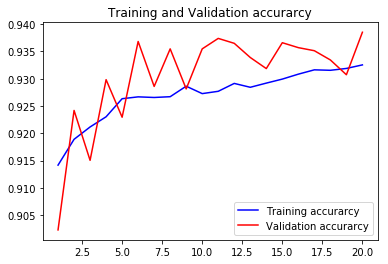

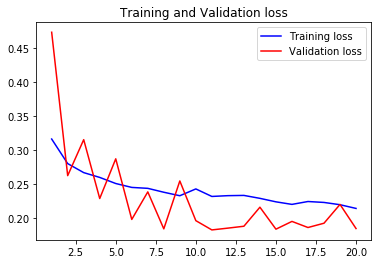

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [31]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
591/591 [==============================] - 27s 46ms/step
Test Accuracy: 93.85223105272465


Save model using Pickle

In [32]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


#### Convert to IOS model

In [33]:
from keras.models import load_model
import coremltools
import re

In [34]:
clean_label = []
for l in label_binarizer.classes_.tolist():
    name = re.split("[_]+", l.lower())
    crop = name[0]
    disease = " ".join(name[1:])
    clean_name = "{}: {}".format(crop, disease)
    clean_label.append(clean_name)
    print(clean_name)

pepper: bell bacterial spot
pepper: bell healthy
potato: early blight
potato: late blight
potato: healthy
tomato: bacterial spot
tomato: early blight
tomato: late blight
tomato: leaf mold
tomato: septoria leaf spot
tomato: spider mites two spotted spider mite
tomato: target spot
tomato: tomato yellowleaf curl virus
tomato: tomato mosaic virus
tomato: healthy


In [35]:
print("[INFO] converting model")
class_labels = label_binarizer.classes_.tolist()
coreml_model = coremltools.converters.keras.convert(model,
                                                    input_names="image",
                                                    image_input_names="image",
                                                    image_scale=1/255.0,
                                                    class_labels=class_labels,
                                                    is_bgr=True)

[INFO] converting model
0 : conv2d_6_input, <keras.engine.input_layer.InputLayer object at 0x1a29d85c18>
1 : conv2d_6, <keras.layers.convolutional.Conv2D object at 0x117fdd1d0>
2 : activation_8, <keras.layers.core.Activation object at 0x117fdd780>
3 : batch_normalization_7, <keras.layers.normalization.BatchNormalization object at 0x1a29d85c50>
4 : max_pooling2d_4, <keras.layers.pooling.MaxPooling2D object at 0x1a29d85d30>
5 : conv2d_7, <keras.layers.convolutional.Conv2D object at 0x1a29d7fb38>
6 : activation_9, <keras.layers.core.Activation object at 0x1a29d85d68>
7 : batch_normalization_8, <keras.layers.normalization.BatchNormalization object at 0x1a3c864da0>
8 : conv2d_8, <keras.layers.convolutional.Conv2D object at 0x1af97be7f0>
9 : activation_10, <keras.layers.core.Activation object at 0x1af97be940>
10 : batch_normalization_9, <keras.layers.normalization.BatchNormalization object at 0x1af986acf8>
11 : max_pooling2d_5, <keras.layers.pooling.MaxPooling2D object at 0x1af9828e80>
12 : 

In [36]:
output = 'PlantDisease.mlmodel'
print("[INFO] saving model as {}".format(output))
coreml_model.save(output)

[INFO] saving model as PlantDisease.mlmodel
